## DATA IMPORT

In [1]:
import pandas as pd

train_data = pd.read_csv('data/train.csv')
print('Training data set: ' + str(len(train_data)))

#train_data.head()

Training data set: 1306122


## DATA WRANGLING

In [2]:
%%time

import contractions
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
#nltk.download()
from nltk.stem import PorterStemmer, WordNetLemmatizer  
from nltk.tokenize import word_tokenize 
from nltk.corpus import  wordnet, stopwords 
from joblib import dump, load

stop_words = set(stopwords.words('english'))

def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)

def remove_white_space(text):
    return text.strip().strip('\t\n')

def remove_special_character(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def porter_stemmer(text): #PorterStemmer
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in word_tokenize(text)])
    return text

def lemmatizer(text): 
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])
    return text

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
    
def remove_stop_word(text): 
    text = ' '.join([w for w in nltk.word_tokenize(text) if w not in stop_words])
    return text

train_data['origin'] = train_data['question_text']
train_data['question_text'] = train_data['question_text'].str.normalize('NFKD')\
.apply(remove_non_ascii).apply(remove_white_space).apply(contractions.fix).str.lower()\
.apply(remove_special_character).apply(remove_stop_word)

train_data['question_text_stem'] = train_data['question_text'].apply(porter_stemmer)
train_data['question_text_lemma'] = train_data['question_text'].apply(lemmatizer)
train_data['word_count'] = train_data['question_text'].apply(lambda x: len(str(x).split()))
train_data = train_data.loc[(train_data.word_count > 0)]
train_data= train_data.reset_index()

print('Training data set: ' + str(len(train_data)))
#print(train_data.head())

filename = 'data/train_data.sav'
dump(train_data, filename)

[nltk_data] Downloading package punkt to /Users/yang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/yang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training data set: 1306020
CPU times: user 31min 28s, sys: 1min 40s, total: 33min 8s
Wall time: 33min 11s


<B>Data Staging</B>

In [3]:
from joblib import dump, load
filename = 'data/train_data.sav'
train_data = load(filename)
print('Training data set: ' + str(len(train_data)))

Training data set: 1306020


In [4]:
%%time

from joblib import dump, load

train_text_lemma = train_data['question_text_lemma']
train_text_stem = train_data['question_text_stem']
train_target = train_data['target']

filename = 'data/target.sav'
dump(train_target, filename)
filename = 'data/question_text_lemma.sav'
dump(train_text_lemma, filename)
filename = 'data/question_text_stem.sav'
dump(train_text_stem, filename)

CPU times: user 1.33 s, sys: 314 ms, total: 1.64 s
Wall time: 1.85 s


## WORD CLOUD 

Just for fun, from <B>[Generating WordClouds in Python](https://www.datacamp.com/community/tutorials/wordcloud-python)</B>

In [33]:
#?WordCloud

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

def word_cloud(text, name):
    plt.figure(figsize=(15,15))
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wordcloud.to_file("image/"+ name +".png")

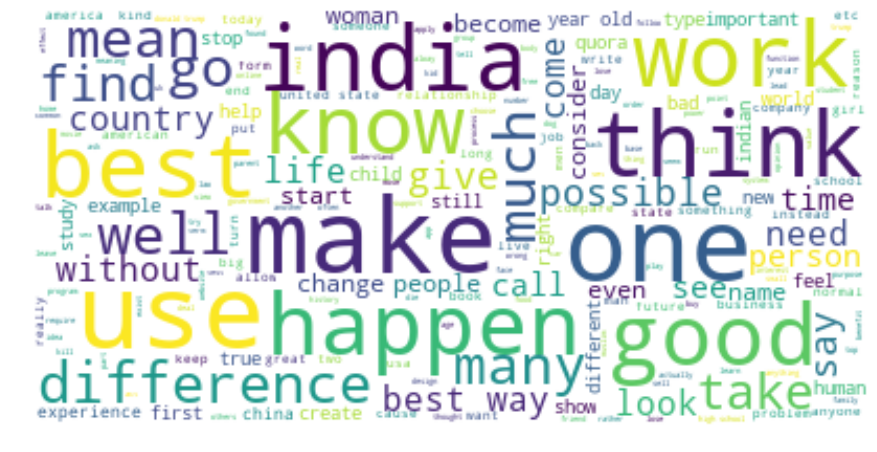

In [6]:
text = " ".join(question for question in train_data.question_text_lemma)
word_cloud(text, 'all_words')

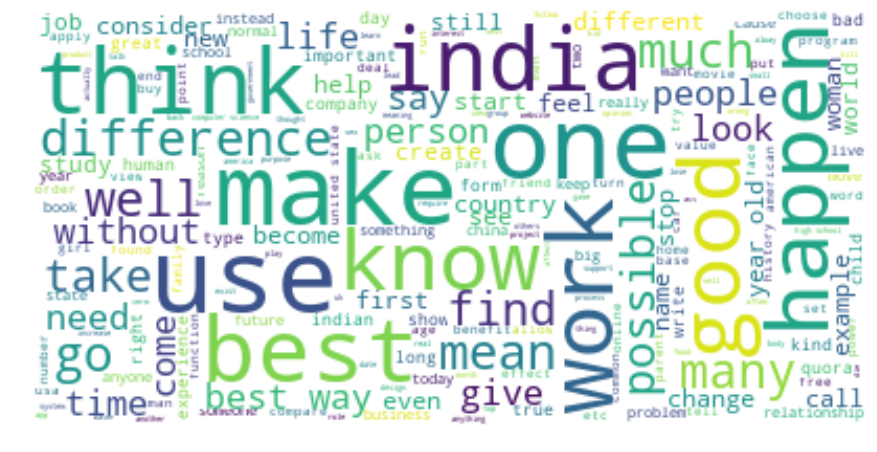

In [7]:
text = " ".join(question for question in train_data.loc[train_data.target == 0,'question_text_lemma'])
word_cloud(text, 'positive_words')

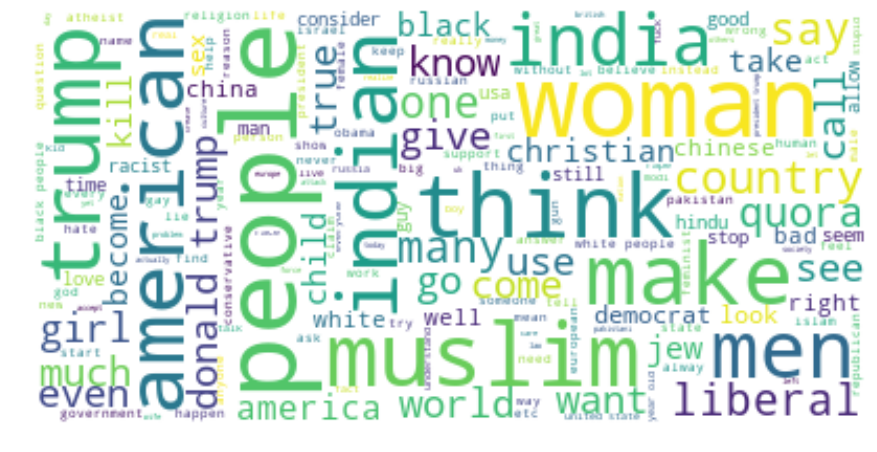

In [8]:
text = " ".join(question for question in train_data.loc[train_data.target == 1,'question_text_lemma'])
word_cloud(text, 'negative_words')

## TRAIN-TEST DATA PREPARATOIN 

## Control and Report Setting

In [1]:
# to store different accuracy result
test_size=0.5
hold_size=0.95
test_compare = {} 
hold_compare = {}

## Bag Of Words Using Traiditonal Machine Learning 

In [2]:
%%time

from joblib import dump, load

filename = 'data/target.sav'
train_target =load(filename)
filename = 'data/question_text_lemma.sav'
train_text_lemma = load(filename)
filename = 'data/question_text_stem.sav'
train_text_stem = load(filename)

CPU times: user 1.29 s, sys: 414 ms, total: 1.71 s
Wall time: 1.71 s


In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

def split(X, y, vectorizer=CountVectorizer(), test_size=0.2, hold_size=0.2):
    #split data to train, test & hold, hold will be completed outside the training vector, 
    X_train, X_hold, y_train, y_hold  = train_test_split(X, y, test_size= hold_size, train_size= 1- hold_size, random_state=42, stratify=y)
    X_train= vectorizer.fit_transform(X_train)
    X_hold= vectorizer.transform(X_hold)
    X_train, X_test, y_train, y_test  = train_test_split(X_train, y_train, test_size= test_size, train_size= 1-test_size, random_state=42, stratify=y_train)
    return  X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer


def fit(X, y, param_grid, estimator):
    search = GridSearchCV(estimator, param_grid, cv=5)
    search.fit(X, y)
    best= search.best_estimator_ 
    best.fit(X, y)
    return best


def report(best, X, y, comp, name):
    target_names = ['Sincere', 'Insincere']
    
    print(best)
    predicted = best.predict(X)
    
    #classification_report 
    report = classification_report(y, predicted, target_names=target_names)
    print(report)
    comp[name] = report

    #confusion matrix
    matrix = confusion_matrix(y, predicted)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(matrix, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    #roc curve
    probs = best.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probs[:,0], pos_label= 0)
    roc_auc = auc(fpr, tpr)
    fpr1, tpr1, thresholds1 = roc_curve(y, probs[:,1], pos_label= 1)
    roc_auc1 = auc(fpr1, tpr1)
    
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=1, label='ROC curve for sincere (area = %0.2f)' % roc_auc)
    plt.plot(fpr1, tpr1, color='red', lw=1, label='ROC curve for insincere (area = %0.2f)' % roc_auc1)
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
# %%time

# X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer = split(train_text_lemma, train_target, CountVectorizer())
# print(X_train.shape,X_test.shape,X_hold.shape)
# print(y_train.shape,y_test.shape,y_hold.shape)
# print(vectorizer)


(835852, 196257) (208964, 196257) (261204, 196257)
(835852,) (208964,) (261204,)
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
CPU times: user 13.2 s, sys: 403 ms, total: 13.6 s
Wall time: 11.8 s


### Grid Search for Algorithm (naive_bayes)

MultinomialNB(alpha=1.7, class_prior=None, fit_prior='True')
              precision    recall  f1-score   support

     Sincere       0.95      0.99      0.97     61261
   Insincere       0.51      0.13      0.20      4040

    accuracy                           0.94     65301
   macro avg       0.73      0.56      0.59     65301
weighted avg       0.92      0.94      0.92     65301



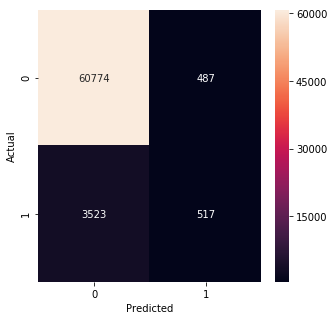

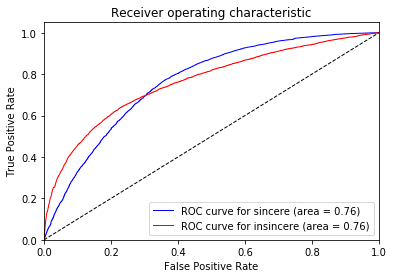

MultinomialNB(alpha=1.7, class_prior=None, fit_prior='True')
              precision    recall  f1-score   support

     Sincere       0.94      1.00      0.97   1102699
   Insincere       0.63      0.11      0.18     72719

    accuracy                           0.94   1175418
   macro avg       0.79      0.55      0.58   1175418
weighted avg       0.92      0.94      0.92   1175418



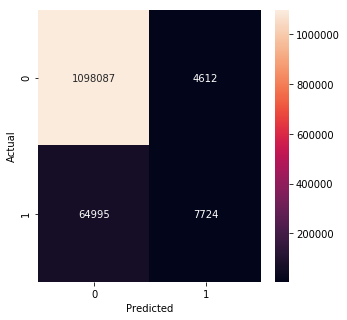

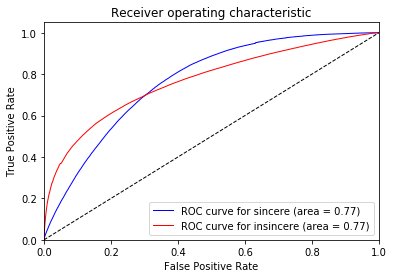

MultinomialNB(alpha=0.8, class_prior=None, fit_prior='True')
              precision    recall  f1-score   support

     Sincere       0.94      1.00      0.97     61261
   Insincere       0.50      0.00      0.00      4040

    accuracy                           0.94     65301
   macro avg       0.72      0.50      0.49     65301
weighted avg       0.91      0.94      0.91     65301



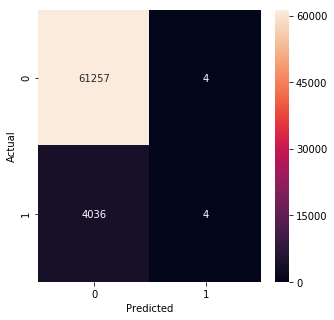

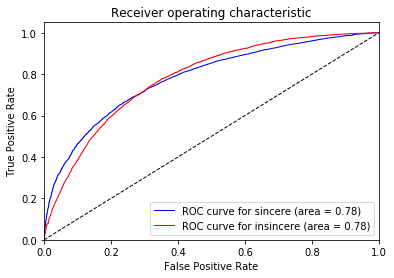

MultinomialNB(alpha=0.8, class_prior=None, fit_prior='True')
              precision    recall  f1-score   support

     Sincere       0.94      1.00      0.97   1102699
   Insincere       0.79      0.00      0.00     72719

    accuracy                           0.94   1175418
   macro avg       0.86      0.50      0.49   1175418
weighted avg       0.93      0.94      0.91   1175418



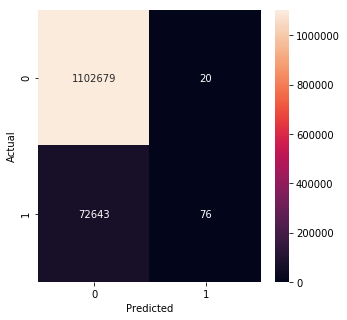

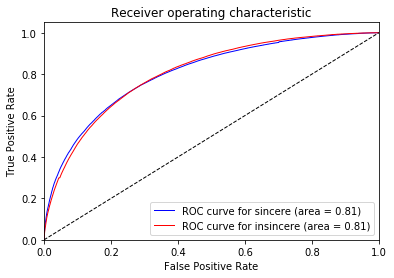

BernoulliNB(alpha=0.5, binarize=0.0, class_prior=None, fit_prior='True')
              precision    recall  f1-score   support

     Sincere       0.95      0.98      0.97     61261
   Insincere       0.53      0.28      0.36      4040

    accuracy                           0.94     65301
   macro avg       0.74      0.63      0.67     65301
weighted avg       0.93      0.94      0.93     65301



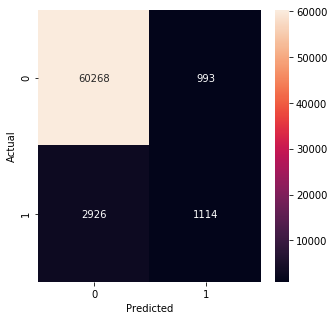

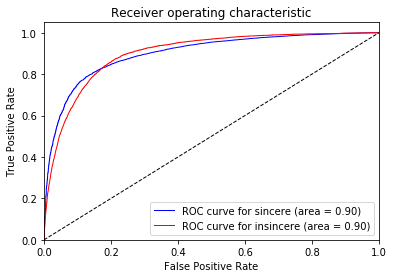

BernoulliNB(alpha=0.5, binarize=0.0, class_prior=None, fit_prior='True')
              precision    recall  f1-score   support

     Sincere       0.95      0.99      0.97   1102699
   Insincere       0.61      0.24      0.35     72719

    accuracy                           0.94   1175418
   macro avg       0.78      0.62      0.66   1175418
weighted avg       0.93      0.94      0.93   1175418



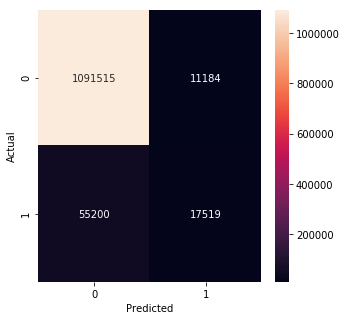

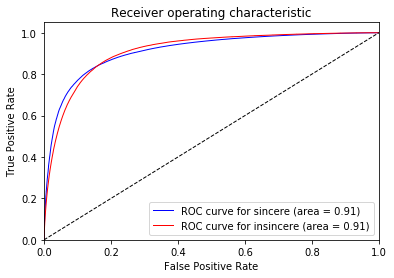

BernoulliNB(alpha=0.5, binarize=0.0, class_prior=None, fit_prior='True')
              precision    recall  f1-score   support

     Sincere       0.95      0.98      0.97     61261
   Insincere       0.53      0.28      0.36      4040

    accuracy                           0.94     65301
   macro avg       0.74      0.63      0.67     65301
weighted avg       0.93      0.94      0.93     65301



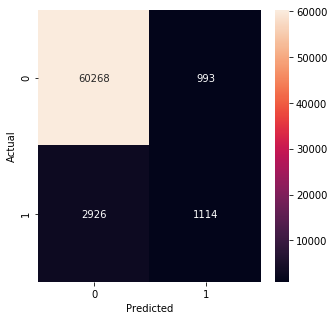

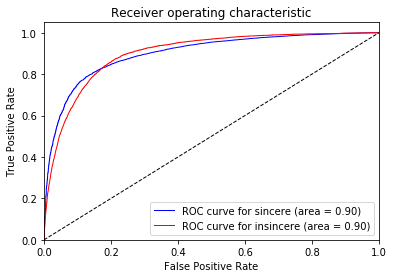

BernoulliNB(alpha=0.5, binarize=0.0, class_prior=None, fit_prior='True')
              precision    recall  f1-score   support

     Sincere       0.95      0.99      0.97   1102699
   Insincere       0.61      0.24      0.35     72719

    accuracy                           0.94   1175418
   macro avg       0.78      0.62      0.66   1175418
weighted avg       0.93      0.94      0.93   1175418



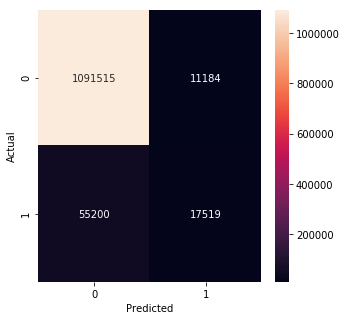

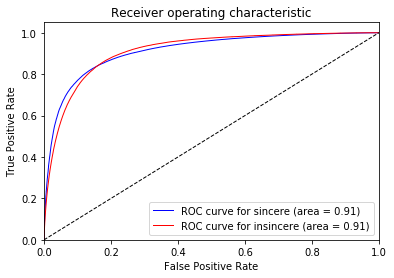

ComplementNB(alpha=2.3000000000000003, class_prior=None, fit_prior='True',
             norm=False)
              precision    recall  f1-score   support

     Sincere       0.95      0.94      0.95     61261
   Insincere       0.26      0.30      0.28      4040

    accuracy                           0.90     65301
   macro avg       0.61      0.62      0.61     65301
weighted avg       0.91      0.90      0.91     65301



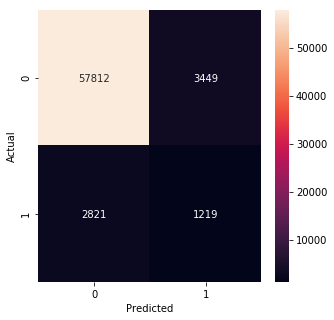

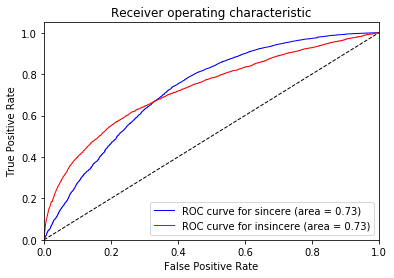

ComplementNB(alpha=2.3000000000000003, class_prior=None, fit_prior='True',
             norm=False)
              precision    recall  f1-score   support

     Sincere       0.95      0.96      0.96   1102699
   Insincere       0.34      0.28      0.31     72719

    accuracy                           0.92   1175418
   macro avg       0.65      0.62      0.63   1175418
weighted avg       0.91      0.92      0.92   1175418



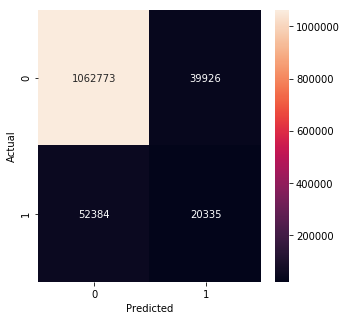

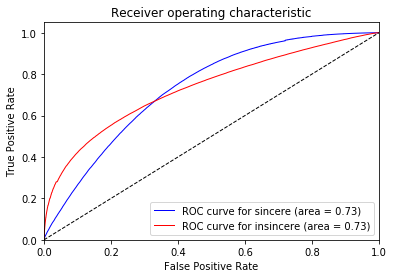

ComplementNB(alpha=2.3000000000000003, class_prior=None, fit_prior='True',
             norm=False)
              precision    recall  f1-score   support

     Sincere       0.94      0.97      0.96     61261
   Insincere       0.20      0.12      0.15      4040

    accuracy                           0.92     65301
   macro avg       0.57      0.54      0.55     65301
weighted avg       0.90      0.92      0.91     65301



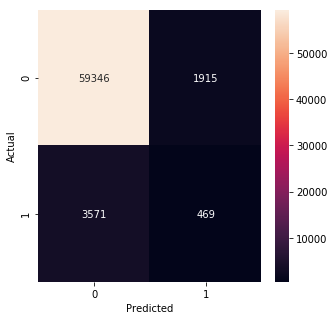

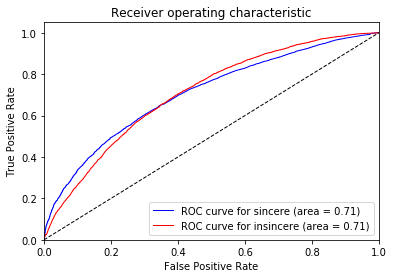

ComplementNB(alpha=2.3000000000000003, class_prior=None, fit_prior='True',
             norm=False)
              precision    recall  f1-score   support

     Sincere       0.94      0.98      0.96   1102699
   Insincere       0.28      0.10      0.14     72719

    accuracy                           0.93   1175418
   macro avg       0.61      0.54      0.55   1175418
weighted avg       0.90      0.93      0.91   1175418



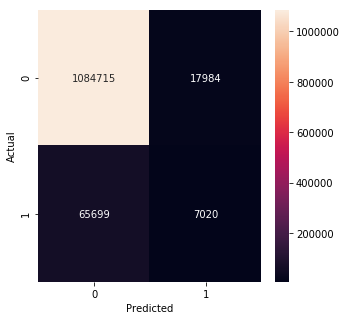

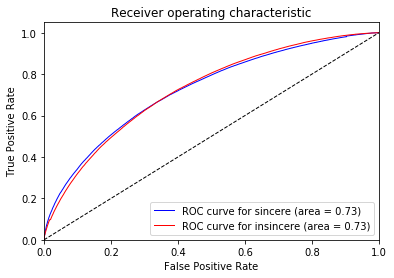

CPU times: user 2min 36s, sys: 6.18 s, total: 2min 42s
Wall time: 1min 38s


In [16]:
%%time

from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

for estimator in ['Multinomial','Bernoulli','Complement']:
    for vectorizer in ['count', 'tfidf']:
        name = estimator+'_lemma_'+ vectorizer
        param_grid = {'alpha': np.arange(0.2, 2.5, 0.3), 'fit_prior':['True','False'],
             } #'scoring':['accuracy','f1_precision','f1','f1_recall']
        if vectorizer == 'count' :
            v = CountVectorizer()
        else:
            v = TfidfVectorizer()
        if estimator =='Multinomial':
            e = MultinomialNB()
        elif estimator =='Bernoulli':
            e = BernoulliNB()
        else:
            e = ComplementNB()
        X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer = split(train_text_lemma, train_target, v, test_size=test_size, hold_size=hold_size)
        best= fit(X_train, y_train, param_grid, e)
        filename = 'data/'+name+'.sav'
        dump(best, filename)
        report(best, X_test, y_test, test_compare, name)
        report(best, X_hold, y_hold, hold_compare, name)
        

### Grid Search for Algorithm (Logistic Regression)

/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.96      0.99      0.97     61261
   Insincere       0.63      0.32      0.42      4040

    accuracy                           0.95     65301
   macro avg       0.79      0.65      0.70     65301
weighted avg       0.94      0.95      0.94     65301



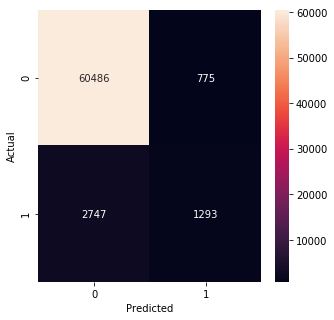

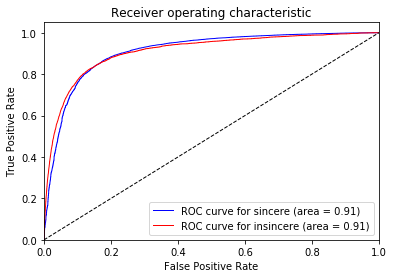

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.96      0.99      0.97   1102699
   Insincere       0.64      0.33      0.44     72719

    accuracy                           0.95   1175418
   macro avg       0.80      0.66      0.70   1175418
weighted avg       0.94      0.95      0.94   1175418



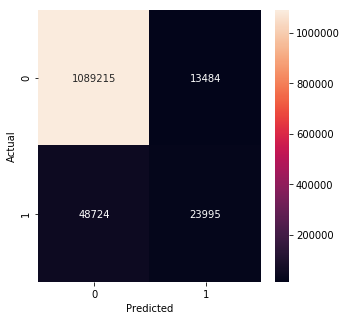

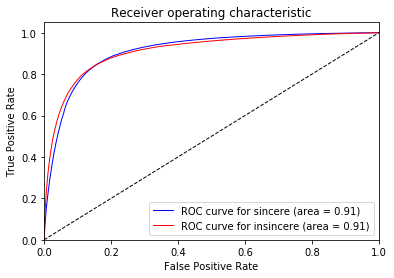

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.96      0.99      0.97     61261
   Insincere       0.62      0.31      0.41      4040

    accuracy                           0.95     65301
   macro avg       0.79      0.65      0.69     65301
weighted avg       0.94      0.95      0.94     65301



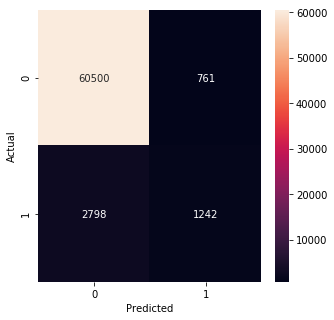

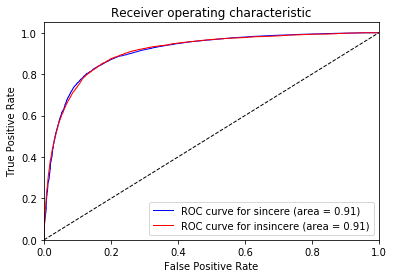

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.96      0.99      0.97   1102699
   Insincere       0.62      0.33      0.43     72719

    accuracy                           0.95   1175418
   macro avg       0.79      0.66      0.70   1175418
weighted avg       0.94      0.95      0.94   1175418



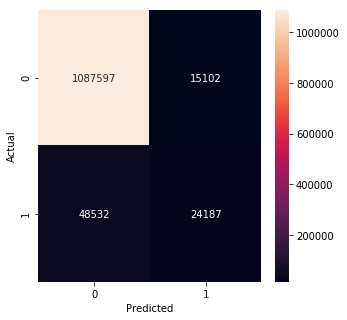

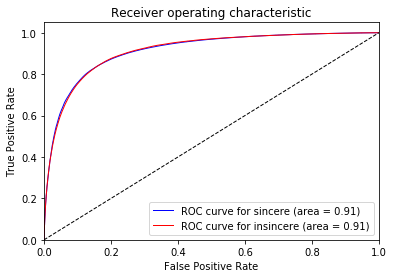

CPU times: user 11min 49s, sys: 14.9 s, total: 12min 4s
Wall time: 5min 13s


In [18]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np


for estimator in ['Logistic',]:
    for vectorizer in ['count', 'tfidf']:
        name = estimator+'_lemma_'+ vectorizer
        param_grid = {'C': [0.001, 0.05, 0.1, 1, 10, 100], 'solver':['newton-cg','lbfgs','sag'],
                     } # 'scoring':['f1_precision','f1','f1_recall'], 'penalty' : ['l1','l2'],
        
        if vectorizer == 'count' :
            v = CountVectorizer()
        else:
            v = TfidfVectorizer()
        
        e = LogisticRegression(max_iter=1000, random_state=42)
        X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer = split(train_text_lemma, train_target, v, test_size=test_size, hold_size=hold_size)
        best= fit(X_train, y_train, param_grid, e)
        filename = 'data/'+name+'.sav'
        dump(best, filename)
        report(best, X_test, y_test, test_compare, name)
        report(best, X_hold, y_hold, hold_compare, name)


### Grid Search for Algorithm (SVM)

In [ ]:
%%time

from sklearn.svm import SVC, LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

for estimator in ['svc',]:
    for vectorizer in ['count', 'tfidf']:
        name = estimator+'_lemma_'+ vectorizer
        param_grid = {'C': [0.001, 0.05, 0.1, 1, 10, 100],
                      'kernel' :['rbf'],
                      'gamma': [0.001, 0.05, 0.1, 1, 10, 100],
                      'class_weight': [None, 'balanced'],
                     } #'scoring':['f1_precision','f1','f1_recall'] 
        if vectorizer == 'count' :
            v = CountVectorizer()
        else:
            v = TfidfVectorizer()
        
        e = SVC(random_state=42, probability=True)
        X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer = split(train_text_lemma, train_target, v, test_size=test_size, hold_size=hold_size)
        best= fit(X_train, y_train, param_grid, e)
        filename = 'data/'+name+'.sav'
        dump(best, filename)
        report(best, X_test, y_test, test_compare, name)
        report(best, X_hold, y_hold, hold_compare, name)

### Grid Search for Algorithm (RandomForestClassifier)

In [ ]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

for estimator in ['forest',]:
    for vectorizer in ['count', 'tfidf']:
        name = estimator+'_lemma_'+ vectorizer
        param_grid = {'n_estimators': [10, 20, 50, 100, 200], 'criterion':['gini','entropy'],
                     } #'scoring':['f1_precision','f1','f1_recall']

        if vectorizer == 'count' :
            v = CountVectorizer()
        else:
            v = TfidfVectorizer()
        
        e = RandomForestClassifier(random_state=42)
        X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer = split(train_text_lemma, train_target, v, test_size=test_size, hold_size=hold_size)
        best= fit(X_train, y_train, param_grid, e)
        filename = 'data/'+name+'.sav'
        dump(best, filename)
        report(best, X_test, y_test, test_compare, name)
        report(best, X_hold, y_hold, hold_compare, name)

### Grid Search for Algorithm (GradientBoostingClassifier)

In [ ]:
%%time

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

for estimator in ['gradientboost',]:
    for vectorizer in ['count', 'tfidf']:
        name = estimator+'_lemma_'+ vectorizer
        param_grid = {'loss' : ['deviance', 'exponential'], 'learning_rate' : np.arange(0.1, 1.2, 0.2),
                      'n_estimators':[10, 20, 50, 100, 200], 'subsample' : np.arange(0.4, 1.1, 0.3),
                      'max_depth' : [3, 8, 13, 20],} #'scoring':['f1_precision','f1','f1_recall']
        
        if vectorizer == 'count' :
            v = CountVectorizer()
        else:
            v = TfidfVectorizer()
        
        e = GradientBoostingClassifier(random_state=42)
        X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer = split(train_text_lemma, train_target, v, test_size=test_size, hold_size=hold_size)
        best= fit(X_train, y_train, param_grid, e)
        filename = 'data/'+name+'.sav'
        dump(best, filename)
        report(best, X_test, y_test, test_compare, name)
        report(best, X_hold, y_hold, hold_compare, name)

## CLASSIFICATION REULT COMPARISON

In [27]:
for key in test_compare:
    print(key)
    print(test_compare[key])

ComplementNB_lemma_Count
              precision    recall  f1-score   support

     Sincere       0.95      0.94      0.95     61261
   Insincere       0.26      0.30      0.28      4040

    accuracy                           0.90     65301
   macro avg       0.61      0.62      0.61     65301
weighted avg       0.91      0.90      0.91     65301

ComplementNB_lemma_Tfidf
              precision    recall  f1-score   support

     Sincere       0.94      0.97      0.96     61261
   Insincere       0.20      0.12      0.15      4040

    accuracy                           0.92     65301
   macro avg       0.57      0.54      0.55     65301
weighted avg       0.90      0.92      0.91     65301

MultinomialNB_lemma_Count
              precision    recall  f1-score   support

     Sincere       0.95      0.99      0.97     61261
   Insincere       0.51      0.13      0.20      4040

    accuracy                           0.94     65301
   macro avg       0.73      0.56      0.59     6530

In [37]:
for key in hold_compare:
    print(key)
    print(hold_compare[key])

ComplementNB_lemma_Count
              precision    recall  f1-score   support

     Sincere       0.95      0.96      0.96   1102699
   Insincere       0.34      0.28      0.31     72719

    accuracy                           0.92   1175418
   macro avg       0.65      0.62      0.63   1175418
weighted avg       0.91      0.92      0.92   1175418

ComplementNB_lemma_Tfidf
              precision    recall  f1-score   support

     Sincere       0.94      0.98      0.96   1102699
   Insincere       0.28      0.10      0.14     72719

    accuracy                           0.93   1175418
   macro avg       0.61      0.54      0.55   1175418
weighted avg       0.90      0.93      0.91   1175418

MultinomialNB_lemma_Count
              precision    recall  f1-score   support

     Sincere       0.94      1.00      0.97   1102699
   Insincere       0.63      0.11      0.18     72719

    accuracy                           0.94   1175418
   macro avg       0.79      0.55      0.58   117541

In [23]:
# import numpy as np
# from sklearn.model_selection import validation_curve
# from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB

# # Calculate accuracy on training and test set using range of parameter values
# param_range=np.logspace(0, 10, 50)
# train_scores, test_scores = validation_curve(ComplementNB(), 
#                                              X_train, 
#                                              y_train, 
#                                              param_name="alpha", 
#                                              param_range=param_range,
#                                              cv=5, 
#                                              scoring="accuracy", 
#                                              n_jobs=-1)


# # Calculate mean and standard deviation for training set scores
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)

# # Calculate mean and standard deviation for test set scores
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# # Plot mean accuracy scores for training and test sets
# plt.plot(param_range, train_mean, label="Training score", color="black")
# plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# # Plot accurancy bands for training and test sets
# plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
# plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# # Create plot
# plt.title("Validation Curve")
# plt.xlabel(r"$\alpha$")
# plt.ylabel("Accuracy Score")
# plt.tight_layout()
# plt.legend(loc="best")
# plt.show()

In [24]:
# from sklearn.model_selection import learning_curve
# train_sizes, train_scores, valid_scores = learning_curve(ComplementNB(), X_train, y_train, train_sizes=np.arange(0.5,1,0.05), cv=5)

# plt.figure()
# plt.plot(train_sizes, train_scores, color='blue', lw=1)
# plt.plot(train_sizes, valid_scores, color='red', lw=1)
# plt.show()